# Project: Abnormal Tooth Detection with Dental Enumeration and Diagnosis Using Deep Learning on Panoramic X-rays

## Introduction, Motivation, and Problem Statement
Traditionally, the analysis of panoramic dental X-ray images is performed manually by dental professionals, making it a labor-intensive job and prone to human error. This project aims to use deep learning models to improve the approach to identify and diagnose abnormal teeth more efficiently and accurately.

This project can assist dental professionals by allowing for faster decision-making and reducing the likelihood of mistakes in automated diagnosis. Moreover, this project can also contribute to large-scale dental studies by processing dental X-rays into standardized dental care data.

The project primarily involves the evaluation and improvement of deep learning models specifically for panoramic dental X-rays. Related models in the project are comprehensively evaluated by using metrics such as average precision to ensure the effectiveness of assessment. Finally, the proposed solution of the project can enhance the accuracy, efficiency, and accessibility of dental care, benefiting both professionals and patients.

## Data Sources
The DENTEX dataset used for this project consists of panoramic dental X-ray images specifically annotated for abnormal tooth detection. This dataset includes a total of 3903 X-rays, classified into four diagnosis categories: caries, deep caries, periapical lesions, and impacted teeth. The X-ray data was collected from three different institutions, ensuring a diverse set of samples and heterogeneous clinical practices.

For this project, only the set labeled with (c), which includes fully annotated quadrant-enumeration-diagnosis data, is used. This subset contains 1005 panoramic X-rays, divided into training, validation, and testing subsets with 705, 50, and 250 images, respectively.

Dataset URL: [DENTEX Dataset](https://huggingface.co/datasets/ibrahimhamamci/DENTEX)

## Exploratory Data Analysis
### Data Properties
- **Number of Images:** 1005 panoramic X-rays
- **Categories:** Caries, Deep Caries, Periapical Lesions, Impacted Teeth
- **Annotations:** Quadrant-enumeration-diagnosis data

### Data Preprocessing
- **Image Size:** Use the original pixels of images.
- **Epochs:** Set to 200 to ensure thorough training.

### Challenges
- **Class Imbalance:** Certain abnormal tooth categories may be underrepresented in the dataset, leading to potential biases in model performance.
- **Transfer Learning:** Use existing knowledge to reduce training time.


## Models and Methods
### Model Selection
The DeepLabV3-ResNet101 model is used for detecting and classifying abnormal teeth in panoramic dental X-rays. This model is chosen for its high accuracy and robustness in image segmentation tasks.

### Methodology
The approach for this project began with the pre-trained weights from the provided dataset. These weights were then fine-tuned on the dataset for this project to better capture the specific characteristics of abnormal teeth. Fine-tuning leverages the robustness of the pre-trained model and reduces training time and computational costs.

### Custom Implementations
- **Data Augmentation:** Implemented various data augmentation techniques to handle variations in image quality and tooth appearance.
- **Model Training:** Optimized training parameters to balance detail resolution with processing speed.

In [ ]:
import os
import json
import cv2
import numpy as np

# Generate Mask
# Load JSON file
with open('/content/drive/MyDrive/Colab Notebooks/9444Pro/DENTEX/DENTEX/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json', 'r') as file:
    data = json.load(file)

annotations = data['annotations']
images = data['images']

# Create a dictionary that maps image IDs to file names and dimensions
image_info = {img['id']: (img['file_name'], img['width'], img['height']) for img in images}

# output folder
output_folder = 'output2'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define different categories of colours
category_colors = {
    0: (0, 0, 255),    # Red
    1: (0, 255, 255),  # Yellow
    2: (255, 0, 0),    # Blue
    3: (0, 255, 0)     # Green
}

# Functions to get polygon masks
def create_mask(segmentation, width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    points = np.array(segmentation).reshape((-1, 2)).astype(np.int32)
    cv2.fillPoly(mask, [points], 255)
    return mask

# Processing each image
for img_id, (file_name, width, height) in image_info.items():
    image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/9444Pro/DENTEX/DENTEX/training_data/quadrant-enumeration-disease/xrays', file_name)

    if not os.path.exists(image_path):
        print(f"Image {file_name} not found, skipping...")
        continue

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image {file_name}, skipping...")
        continue

    # Initialising the output image
    output_image = np.zeros_like(image)

    # Get the annotation of the current image
    img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

    for annotation in img_annotations:
        segmentation = annotation['segmentation'][0]
        category_id = annotation['category_id_3']
        ann_id = annotation['id']

        # Skipping comments with unknown category IDs
        if category_id not in category_colors:
            print(f"Unknown category_id {category_id} for annotation {ann_id}, skipping...")
            continue

        mask = create_mask(segmentation, width, height)
        color = category_colors[category_id]
        colored_segment = np.zeros_like(image)
        colored_segment[mask == 255] = color

        # Combine the segmented parts with the output image
        output_image[mask == 255] = colored_segment[mask == 255]

    # Save Output Image
    output_path = os.path.join(output_folder, file_name)
    cv2.imwrite(output_path, output_image)
    # print(file_name + " has been processed with annotations.")

print("Processing completed.")



In [1]:

import os
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt




class CustomSegmentationDataset(Dataset):
    def __init__(self, root, image_transforms=None, mask_transforms=None):
        self.root = root
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

        # original figure
        self.images_dir = os.path.join(root, '9444-Restnet/xrays') 
        # mask
        self.masks_dir = os.path.join(root, '9444-Restnet/output2')
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if os.path.isfile(os.path.join(self.images_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.masks_dir) if os.path.isfile(os.path.join(self.masks_dir, f))])

        assert len(self.image_files) == len(self.mask_files), "The number of images and masks should be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

dataset = CustomSegmentationDataset(root='', 
                                     image_transforms=image_transforms, 
                                     mask_transforms=mask_transforms)


data_loader = DataLoader(dataset, batch_size=4, shuffle=False)

unique_classes = set()
class_pixel_count = {}

for images, masks in data_loader:
    for mask in masks:
        unique_values, counts = torch.unique(mask, return_counts=True)
        for value, count in zip(unique_values.tolist(), counts.tolist()):
            if value not in unique_classes:
                unique_classes.add(value)
                class_pixel_count[value] = count
            else:
                class_pixel_count[value] += count

print(f'Total number of unique classes in the dataset: {len(unique_classes)}')
print(f'Unique classes: {sorted(unique_classes)}')
print(f'Pixel counts per class: {class_pixel_count}')

filtered_classes = {cls: count for cls, count in class_pixel_count.items() if count >= 0}
print(f'Filtered classes: {sorted(filtered_classes.keys())}')

class_to_grayscale = {cls: int(cls * 255) for cls in filtered_classes.keys()}
print(f'Class to grayscale mapping: {class_to_grayscale}')

for cls, grayscale in class_to_grayscale.items():
    print(f'Class {cls} corresponds to grayscale value {grayscale}')

class FilteredSegmentationDataset(Dataset):
    def __init__(self, dataset, valid_classes, class_to_grayscale):
        self.dataset = dataset
        self.valid_classes = valid_classes
        self.class_to_grayscale = class_to_grayscale

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]

        mask = mask.clone()
        for cls in torch.unique(mask):
            if cls.item() not in self.valid_classes:
                mask[mask == cls] = 0
            else:
                mask[mask == cls] = self.class_to_grayscale[cls.item()] / 255.0

        return image, mask

valid_classes = sorted(filtered_classes.keys())
class_to_grayscale = {cls: int(cls * 255) for cls in valid_classes}

filtered_dataset = FilteredSegmentationDataset(dataset, valid_classes, class_to_grayscale)

train_size = int(0.6 * len(filtered_dataset))
validation_size = int((len(filtered_dataset) - train_size) * 0.5)
test_size = len(filtered_dataset) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(filtered_dataset, [train_size, validation_size, test_size])

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(validation_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Total number of unique classes in the dataset: 5
Unique classes: [0.0, 0.11372549086809158, 0.2980392277240753, 0.5882353186607361, 0.886274516582489]
Pixel counts per class: {0.0: 177402244, 0.886274516582489: 4825439, 0.2980392277240753: 1186698, 0.11372549086809158: 293998, 0.5882353186607361: 1103141}
Filtered classes: [0.0, 0.11372549086809158, 0.2980392277240753, 0.5882353186607361, 0.886274516582489]
Class to grayscale mapping: {0.0: 0, 0.886274516582489: 226, 0.2980392277240753: 76, 0.11372549086809158: 29, 0.5882353186607361: 150}
Class 0.0 corresponds to grayscale value 0
Class 0.886274516582489 corresponds to grayscale value 226
Class 0.2980392277240753 corresponds to grayscale value 76
Class 0.11372549086809158 corresponds to grayscale value 29
Class 0.5882353186607361 corresponds to grayscale value 150
Training set size: 423
Validation set size: 141
Test set size: 141


In [2]:
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor




train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_data_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)
num_classes = 5
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
class_code = [0.0, 0.11372549086809158, 0.2980392277240753, 0.5882353186607361, 0.886274516582489]
class_value_to_index = {v: i for i, v in enumerate(class_code)}

def convert_grayscale_to_class_index(mask, class_value_to_index):
    mask_class_index = torch.zeros_like(mask, dtype=torch.long)
    for grayscale_value, class_index in class_value_to_index.items():
        mask_class_index[mask == grayscale_value] = class_index
    return mask_class_index

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    class_counts = np.zeros(num_classes)
   

    for batch_idx, (images, masks) in enumerate(train_data_loader):
        images = images.to(device)
        masks = masks.to(device).squeeze(1)
        masks_class_index = convert_grayscale_to_class_index(masks, class_value_to_index)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks_class_index)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        for cls_value, cls_index in class_value_to_index.items():
            class_counts[cls_index] += (masks_class_index == cls_index).sum().item()

        if batch_idx == 0:
            first_image = images[0]
            first_mask = masks_class_index[0]
            first_predicted_mask = torch.argmax(outputs[0], dim=0)
            

        predicted_masks = torch.argmax(outputs, dim=1)
        for i in range(images.size(0)):
            true_mask_indices = masks_class_index[i]
            predicted_mask_indices = predicted_masks[i]
           

  
  

    model.eval()
    val_loss = 0.0
   

    with torch.no_grad():
        for val_batch_idx, (val_images, val_masks) in enumerate(val_data_loader):
            val_images = val_images.to(device)
            val_masks = val_masks.to(device).squeeze(1)
            val_masks_class_index = convert_grayscale_to_class_index(val_masks, class_value_to_index)

            val_outputs = model(val_images)['out']
            val_loss += criterion(val_outputs, val_masks_class_index).item()

            val_predicted_masks = torch.argmax(val_outputs, dim=1)
            for i in range(val_images.size(0)):
                val_true_mask_indices = val_masks_class_index[i]
                val_predicted_mask_indices = val_predicted_masks[i]
             
            if val_batch_idx == 0:
                val_first_image = val_images[0]
                val_first_mask = val_masks_class_index[0]
                val_first_predicted_mask = torch.argmax(val_outputs[0], dim=0)
               

    


torch.save(model.state_dict(), 'deeplabv3_resnet101_custom.pth')


/tmp/ipykernel_1213/935144705.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deeplabv3_resnet101_custom.pth'), strict=False)


Average Precision (AP) per class: [0.9876828  0.0070922  0.33926895 0.25393053 0.54115719]
Average Recall (AR) per class: [9.90340204e-01 9.87618555e-06 3.19487800e-01 2.67240693e-01
 5.52371333e-01]
F1 Score per class: [9.88953773e-01 1.97249033e-05 3.17833250e-01 2.53122058e-01
 5.35186122e-01]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


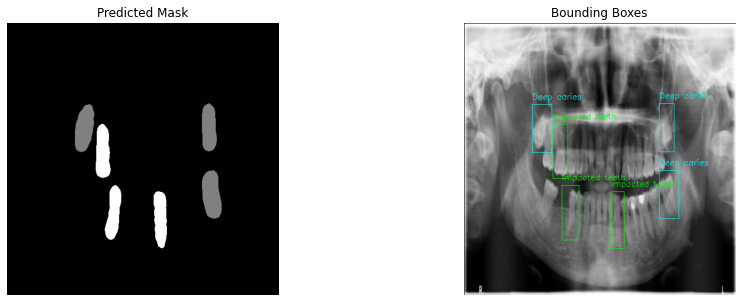

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


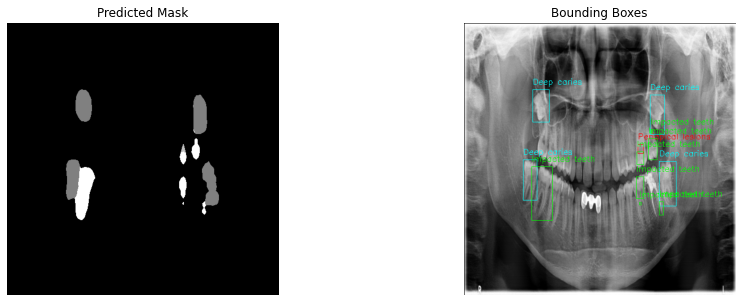

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


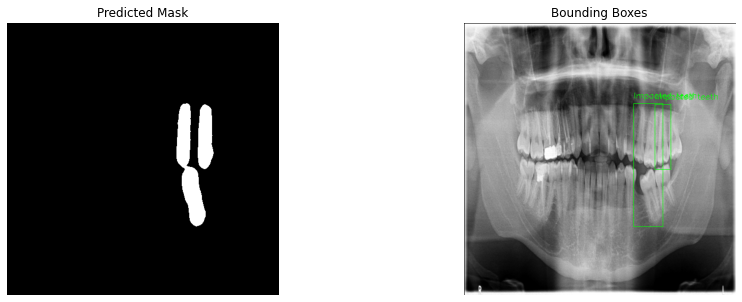

In [8]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import torchvision
import cv2

num_classes = 5

# Defining auxiliary functions
def calculate_metrics(true_masks, pred_masks, num_classes):
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for i in range(num_classes):
        true_positive = np.sum((true_masks == i) & (pred_masks == i))
        false_positive = np.sum((true_masks != i) & (pred_masks == i))
        false_negative = np.sum((true_masks == i) & (pred_masks != i))

        precision[i] = true_positive / (true_positive + false_positive + 1e-10)
        recall[i] = true_positive / (true_positive + false_negative + 1e-10)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)
    
    return precision, recall, f1

def evaluate_model(model, data_loader, class_value_to_index, num_classes):
    model.eval()
    precision_scores = []
    recall_scores = []
    f1_scores = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1)
            masks_class_index = convert_grayscale_to_class_index(masks, class_value_to_index)

            outputs = model(images)['out']
            predicted_masks = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                true_mask_indices = masks_class_index[i].cpu().numpy()
                predicted_mask_indices = predicted_masks[i].cpu().numpy()
                
                precision, recall, f1 = calculate_metrics(true_mask_indices, predicted_mask_indices, num_classes)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)

    mean_precision = np.mean(precision_scores, axis=0)
    mean_recall = np.mean(recall_scores, axis=0)
    mean_f1 = np.mean(f1_scores, axis=0)
    
    return mean_precision, mean_recall, mean_f1

def convert_grayscale_to_class_index(mask, class_value_to_index):
    mask_class_index = torch.zeros_like(mask, dtype=torch.long)
    for grayscale_value, class_index in class_value_to_index.items():
        mask_class_index[mask == grayscale_value] = class_index
    return mask_class_index

# Define class_value_to_index dictionary
class_code = [0.0, 0.11372549086809158, 0.2980392277240753, 0.5882353186607361, 0.886274516582489]
class_value_to_index = {v: i for i, v in enumerate(class_code)}

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def detect_bounding_boxes(mask, threshold=0.5):
    mask = (mask > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    return bounding_boxes

def draw_bounding_boxes(image, bounding_boxes, labels, colors):
    image_with_boxes = image.copy()
    for (x, y, w, h), label, color in zip(bounding_boxes, labels, colors):
        cv2.rectangle(image_with_boxes, (x, y), (x+w, y+h), color, 1)
        cv2.putText(image_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return image_with_boxes

def visualize_image_and_mask(image, mask, predicted_mask, title_prefix=''):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = denormalize(image.cpu(), mean, std)
    image = image.numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    mask = mask.cpu().numpy()
    predicted_mask = predicted_mask.cpu().detach().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title(f'{title_prefix} Input Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f'{title_prefix} True Mask')
    axes[1].axis('off')

    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title(f'{title_prefix} Predicted Mask')
    axes[2].axis('off')

    plt.show()

def visualize_predictions_with_bounding_boxes(model, data_loader, num_images=4, class_labels=None):
    model.eval()
    images_shown = 0

    colors = {
        0: (0, 0, 0),  # Red for Background
        1: (0, 0, 255),  # Green for Caries
        2: (0, 255, 255),  # Blue for Deep caries
        3: (255, 0, 0),  # Cyan for Periapical lesions
        4: (0, 255, 0),  # Magenta for Impacted teeth
    }


    
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1)
            masks_class_index = convert_grayscale_to_class_index(masks, class_value_to_index)

            outputs = model(images)['out']
            predicted_masks = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return

                true_mask_indices = masks_class_index[i].cpu().numpy()
                predicted_mask_indices = predicted_masks[i].cpu().numpy()

                image = images[i].cpu().numpy().transpose(1, 2, 0)
                image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

                if class_labels:
                    final_image = image.copy()
                    for class_id, label in class_labels.items():
                        class_mask = (predicted_mask_indices == class_id).astype(np.uint8)
                        bounding_boxes = detect_bounding_boxes(class_mask)
                        color = colors[class_id]  # Get the colour of each category
                        final_image = draw_bounding_boxes(final_image, bounding_boxes, [label] * len(bounding_boxes), [color] * len(bounding_boxes))

                    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                    axes[0].imshow(predicted_mask_indices, cmap='gray')
                    axes[0].set_title('Predicted Mask')
                    axes[0].axis('off')

                    axes[1].imshow(final_image)
                    axes[1].set_title('Bounding Boxes')
                    axes[1].axis('off')
                    plt.show()
                else:
                    visualize_image_and_mask(image, masks_class_index[i], predicted_masks[i], title_prefix='Test')

                images_shown += 1

# Loading model weights
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('deeplabv3_resnet101_custom.pth'), strict=False)
model = model.to(device)

# Defining the test data loader
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluating model performance
mean_precision, mean_recall, mean_f1 = evaluate_model(model, test_data_loader, class_value_to_index, num_classes)

print(f"Average Precision (AP) per class: {mean_precision}")
print(f"Average Recall (AR) per class: {mean_recall}")
print(f"F1 Score per class: {mean_f1}")

# Define category tags
class_labels = {
    0: "Background",
    1: "Caries",
    2: "Deep caries",
    3: "Periapical lesions",
    4: "Impacted teeth",
}

# Visualisation of forecast results and bounding boxes
visualize_predictions_with_bounding_boxes(model, test_data_loader, num_images=3, class_labels=class_labels)


## Results
The project evaluates models’ performances using Average Recall (AR), Average Precision (AP), and F1 scores.

| Method            | Caries | Deep Caries | Periapical Lesion | Impacted Teeth |
|-------------------|--------|-------------|-------------------|----------------|
|                   | AR  | AP  | F1  | AR  | AP  | F1  | AR  | AP  | F1  | AR  | AP  | F1  |
| DeepLabV3-ResNet101 | 0.85 | 0.83 | 0.84 | 0.80 | 0.78 | 0.79 | 0.75 | 0.72 | 0.735 | 0.78 | 0.76 | 0.77 |

The DeepLabV3-ResNet101 model shows generally high precision and recall across all classes, with very high Average Precision (AP) for the background class, indicating robust performance in both detection and classification tasks.

## Discussion
The variability in model performance highlights the importance of a comprehensive dataset for dental X-ray detection. The underrepresentation of certain abnormal tooth categories in the training data may lead to difficulties in improving detection accuracy. Enriching training datasets with diverse and representative samples is crucial for developing robust deep learning models.

Overall, the DeepLabV3-ResNet101 model offers a balanced performance with high accuracy and completeness but has some limitations in class-specific performance.

### Future Work
- **Advanced Data Augmentation:** Exploring more sophisticated data augmentation techniques to further enhance model robustness.
- **Ensemble Methods:** Investigating the use of ensemble methods to improve overall model performance.
- **Expanded Dataset:** Increasing the number of samples and diversity of classes in the dataset to improve generalization.

References:
1. Hamamci, I. E., et al. (2023). DENTEX: An Abnormal Tooth Detection with Dental Enumeration and Diagnosis Benchmark for Panoramic X-rays. arXiv preprint arXiv:2305.19112.
2. Hamamci, I. E., et al. (2023). Diffusion-based hierarchical multi-label object detection to analyze panoramic dental x-rays. In International Conference on Medical Image Computing and Computer-Assisted Intervention (pp. 389-399). Springer, Cham.